In [ ]:
# !ls -R /kaggle/input/dataset/

Тут импорты

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import f1_score

Тут задал имена столбцам чтоб удобнее было

In [2]:
df = pd.read_csv('/kaggle/input/dataset/dataset/train_solution.csv',
                 header=None,
                names=['filename', 'label'])
print(df.head())
df['filename'] = df['filename'].astype(str) + '.jpg'

   filename  label
0         0      0
1         1      1
2         2      1
3         3      0
4         4      0


Тут посмотрел на изображения

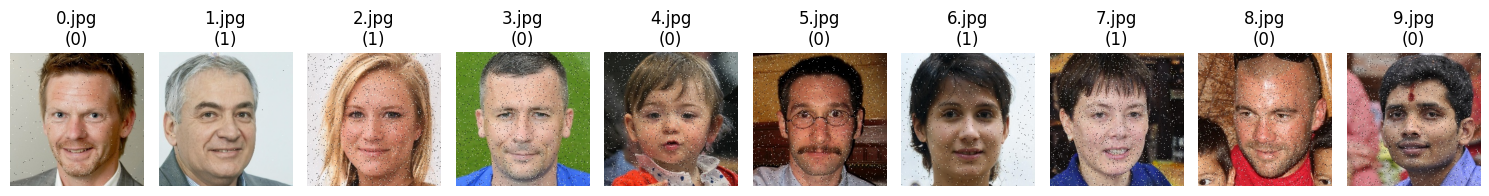

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

img_dir = '/kaggle/input/dataset/dataset/train_images'



sample = df.head(10)



fig, axes = plt.subplots(1, 10, figsize=(15, 3))

for i, row in sample.iterrows():
    img_name = row['filename']
    label = row['label']

    img_path = os.path.join(img_dir, img_name)
    img = Image.open(img_path)

    axes[i].imshow(img)
    axes[i].set_title(f"{img_name}\n({label})")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Тут сравнил как оно очищается

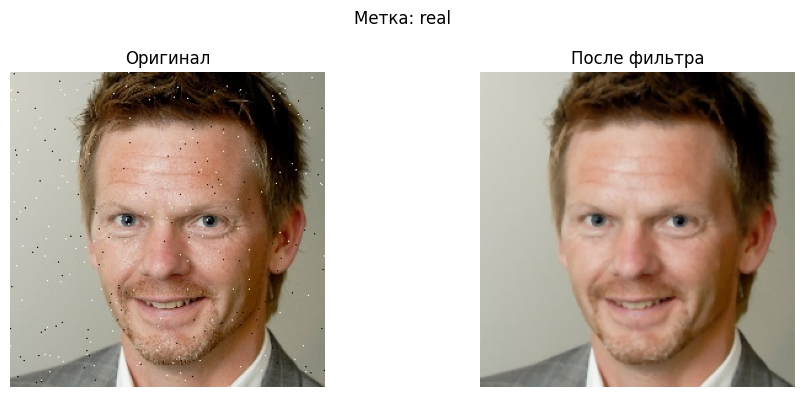

In [5]:
img_path = os.path.join('/kaggle/input/dataset/dataset/train_images', df['filename'].iloc[0])
label = df['label'].iloc[0]

img = cv2.imread(img_path)

denoised = cv2.medianBlur(img, ksize=3)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
denoised_rgb = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2 ,figsize = (10,4))
axes[0].imshow(img_rgb)
axes[0].set_title("Оригинал")
axes[0].axis("off")

axes[1].imshow(denoised_rgb)
axes[1].set_title("После фильтра")
axes[1].axis('off')

plt.suptitle(f"Метка: {'fake' if label == 1 else 'real'}")
plt.tight_layout()
plt.show()

Тут я подбирал mean и std

In [ ]:
# import numpy as np
# from tqdm import tqdm
# from PIL import Image
# import os

# img_dir = 'dataset/train_images'
# filenames = df['filename'].tolist()

# pixel_sum = np.zeros(3, dtype=np.float64)
# pixel_sum_sq = np.zeros(3, dtype=np.float64)
# total_pixels = 0

# for filename in tqdm(filenames, desc="Подсчёт статистики"):
#     img_path = os.path.join(img_dir, filename)
#     img = Image.open(img_path).convert('RGB')
#     img_array = np.array(img, dtype=np.float64)

#     # Считаем в диапазоне [0, 1] сразу
#     img_normalized = img_array / 255.0

#     pixel_sum += img_normalized.sum(axis=(0, 1))
#     pixel_sum_sq += (img_normalized ** 2).sum(axis=(0, 1))
#     total_pixels += img_normalized.shape[0] * img_normalized.shape[1]

# # Вычисляем mean и std
# mean = pixel_sum / total_pixels

# # Дисперсия с защитой от отрицательных значений
# variance = (pixel_sum_sq / total_pixels) - (mean ** 2)
# variance = np.clip(variance, 1e-10, None)  # заменяем отрицательные на маленькое положительное
# std = np.sqrt(variance)

# print("Твои значения для Normalize:")
# print(f"mean = [{mean[0]:.3f}, {mean[1]:.3f}, {mean[2]:.3f}]")
# print(f"std  = [{std[0]:.3f}, {std[1]:.3f}, {std[2]:.3f}]")

Это класс очистки изображений

In [7]:
class MedianDenoise:
    def __init__(self, kernel_size=3):
        assert kernel_size % 2 == 1 and kernel_size >= 3, "kernel_size должен быть нечётным и >= 3"
        self.kernel_size = kernel_size

    def __call__(self, img):
        # Преобразуем PIL Image в массив NumPy (в формате RGB)
        img_np = np.array(img)
        # Конвертируем в BGR, так как OpenCV использует BGR
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        # Применяем медианный фильтр
        denoised_bgr = cv2.medianBlur(img_bgr, self.kernel_size)
        # Обратно в RGB
        denoised_rgb = cv2.cvtColor(denoised_bgr, cv2.COLOR_BGR2RGB)
        # Возвращаем как PIL Image
        return Image.fromarray(denoised_rgb)

Это трейновый и тестовый датасеты

In [8]:
from torch.utils.data import Dataset

class TrainDataset(Dataset):
  def __init__(self, dataframe, img_dir, transform=None):
    self.df = dataframe
    self.img_dir = img_dir
    self.transform = transform
  def __len__(self):
    return(len(self.df))
  def __getitem__(self, idx):
    img_name = self.df.iloc[idx]["filename"]
    label = self.df.iloc[idx]["label"]
    img_path = os.path.join(self.img_dir, img_name)

    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image, label

In [9]:
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.filenames = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name

In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df['label'],
    random_state=42
)
num_0 = len(train_df[train_df['label'] == 0])
num_1 = len(train_df[train_df['label'] == 1])
weight = num_0 / num_1

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]).to(device))

Тут трансформации 

In [18]:

train_transform = transforms.Compose([
    MedianDenoise(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.519, 0.428, 0.384], std=[0.286, 0.264, 0.264])
])



val_test_transform = transforms.Compose([
    MedianDenoise(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.519, 0.428, 0.384], std=[0.286, 0.264, 0.264])
])

In [12]:
from torch.utils.data import DataLoader

train_data = TrainDataset(
    dataframe=train_df,
    img_dir = '/kaggle/input/dataset/dataset/train_images',
    transform = train_transform
)
val_data = TrainDataset(
    dataframe=val_df,
    img_dir='/kaggle/input/dataset/dataset/train_images',
    transform = val_test_transform
)

test_dataset = TestDataset('/kaggle/input/dataset/dataset/test_images', val_test_transform)


train_loader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_data,
    batch_size=32,
    shuffle=False
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
    )

In [13]:
def train(model, loader, criterion, optimizer, device):
  model.train()
  total_loss = 0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []
  for images, labels in tqdm(loader, desc="Обучение", leave=False):
    images = images.to(device)
    labels = labels.float().unsqueeze(1).to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()


    predicted = (torch.sigmoid(outputs) > 0.5).long().cpu().numpy().flatten()
    true_labels = labels.long().cpu().numpy().flatten()
    correct +=(predicted == true_labels).sum().item()
    total += labels.size(0)
    all_preds.extend(predicted)
    all_labels.extend(true_labels)

  f1 = f1_score(all_labels, all_preds, average='macro')
  acc = 100* correct/total
  return total_loss / len(loader), acc, f1

In [14]:
def val(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Валидация", leave=False):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).long().cpu().numpy().flatten()
            true_labels = labels.long().cpu().numpy().flatten()

            correct += (predicted == true_labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted)
            all_labels.extend(true_labels)
    f1 = f1_score(all_labels, all_preds, average='macro')
    acc = 100 * correct / total
    return total_loss / len(loader), acc, f1

Первая модель. Она довольно простая и много из нее не выжмешь

In [15]:
class FirstModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32,64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(64,128,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(128,256,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((4, 4)),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256*4*4, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )
  def forward(self, x):
      x = self.features(x)
      return self.classifier(x)

Это вторая. Обычно она самые лучшие результаты показывала

In [16]:
class SecondModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),


        nn.Conv2d(64,128,kernel_size=3,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((4, 4)),
        nn.Flatten(),

        nn.Linear(512 * 4 * 4, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(512, 1)
    )


  def forward(self, x):
      return self.model(x)

Тут еще третья была но она была излишне сложной и на каком то этапе я ее удалил

Это я проверял чекпоинты обучения чтобы если обучение прервалось с того же места начать

In [ ]:
import os

import torch
checkpoint = torch.load('/kaggle/input/pravchec/checkpoint.pth', weights_only=False, map_location=device)
print("Последняя сохранённая эпоха:", checkpoint['epoch'])

Вот само обучение. В нем есть чекпоинты и сохранение лучших весов

🎉 Новый рекорд! F1: 0.8731 на эпохе 6


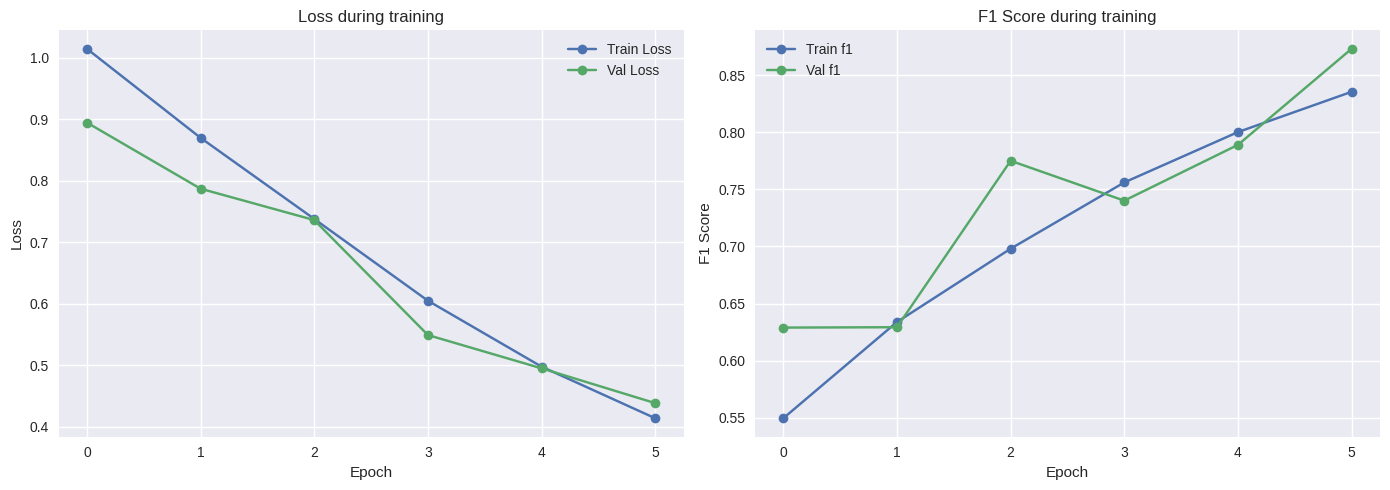

Epoch 6/20 | Train Loss: 0.4140, Acc: 89.41%, F1: 0.8355 | Val Loss: 0.4386, Acc: 92.85%, F1: 0.8731


Обучение:  82%|████████▏ | 1094/1329 [05:32<01:11,  3.29it/s]

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim
from IPython.display import clear_output
from tqdm import tqdm

model =  SecondModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
pos_weight = torch.tensor([4.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
num_epochs = 20

# Это для того чтобы с сохраненного чекпоинта начать


# if os.path.exists('checkpoint.pth'):
#     checkpoint = torch.load('/kaggle/input/pravchec/checkpoint.pth', weights_only=False, map_location=device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     start_epoch = 0
#     train_losses = checkpoint['train_losses']
#     train_accuracies = checkpoint['train_accuracies']  
#     val_losses = checkpoint['val_losses']
#     val_accuracies = checkpoint['val_accuracies']
#     train_f1s = checkpoint['train_f1s']
#     val_f1s = checkpoint['val_f1s']
#     best_val_f1 = checkpoint['best_val_f1']
# else:
#     start_epoch = 0
#     train_losses = []
#     train_accuracies = []
#     val_losses = []
#     val_accuracies = []
#     train_f1s = []
#     val_f1s = []
#     best_val_f1 = 0.0


start_epoch = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
train_f1s = []
val_f1s = []
best_val_f1 = 0.0

best_val_acc = 0.0
plt.style.use('seaborn-v0_8')
best_val_f1 = 0.0
best_epoch = 0

for epoch in range(start_epoch,num_epochs):

    train_loss, train_acc, train_f1 = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = val(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    clear_output(wait=True)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch


        torch.save(model.state_dict(), 'best_model_by_val_f1.pth')

        print(f"🎉 Новый рекорд! F1: {val_f1:.4f} на эпохе {epoch+1}")

    ax[0].plot(train_losses, label='Train Loss', marker='o')
    ax[0].plot(val_losses, label='Val Loss', marker='o')
    ax[0].set_title('Loss during training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True)


    ax[1].plot(train_f1s, label='Train f1', marker='o')
    ax[1].plot(val_f1s, label='Val f1', marker='o')
    ax[1].set_title('F1 Score during training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('F1 Score')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()


    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'best_val_f1': best_val_f1
    }


    torch.save(checkpoint, 'checkpoint.pth')




    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%, F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, F1: {val_f1:.4f}")

In [22]:
model = SecondModel().to(device)

model.load_state_dict(torch.load('best_model_by_val_f1.pth', map_location=device, weights_only=True))

model.eval()

SecondModel(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

Тут я порог подбирал

In [23]:
import numpy as np  
all_true = []
all_probs = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Collecting validation probs"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()  # вероятности
        all_true.extend(labels.cpu().numpy())
        all_probs.extend(probs)

# Подбираем лучший порог
best_th = 0.5
best_f1 = 0.0

for th in np.arange(0.1, 0.6, 0.01): 
    preds = (np.array(all_probs) > th).astype(int)
    f1 = f1_score(all_true, preds, average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_th = th

print(f"✅ Лучший порог: {best_th:.2f} → F1: {best_f1:.4f}")

✅ Лучший порог: 0.59 → F1: 0.9124


In [20]:
torch.save(model.state_dict(), 'my_best_model3.pth')

Предсказания

In [24]:
predictions = []

with torch.no_grad():
    for batch_idx, (images, filenames) in enumerate(tqdm(test_loader, desc="Predicting")):
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        preds = (probs > 0.59).astype(int)
        start_id = batch_idx * test_loader.batch_size
        
        
        for filename, pred in zip(filenames, preds):
            img_id = int(filename.split('.')[0])  # ← так нужно!
            predictions.append({'id': img_id, 'target_feature': int(pred)})
            

Predicting: 100%|██████████| 313/313 [02:00<00:00,  2.59it/s]


In [26]:
submission_df = pd.DataFrame(predictions)

submission_df.to_csv('submission.csv', index=False)

print("✅ Предсказания сохранены в submission.csv")
print(submission_df.head())

✅ Предсказания сохранены в submission.csv
     id  target_feature
0     0               1
1     1               1
2    10               0
3   100               0
4  1000               0


Посмотреть на них

In [ ]:
d = pd.DataFrame(predictions)
d

Как то вот так